# Temperley's Probabilistic Key Estimation



In [1]:
import numpy as np
import partitura

import matplotlib.pyplot as plt
from scipy.stats import mode

from key_profiles import (
    build_key_profile_matrix, 
    key_prof_maj_kk,
    key_prof_min_kk,
    key_prof_maj_cbms,
    key_prof_min_cbms,
    key_prof_maj_kp,
    key_prof_min_kp,
    MAJOR_KEYS,
    KEYS
)

Here are different pitch distributions for major and minor keys

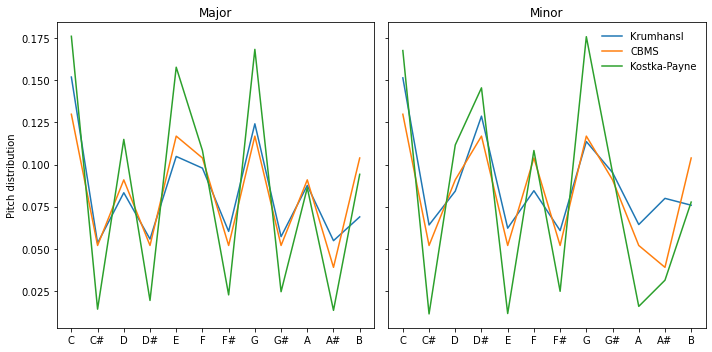

In [2]:
pitch_profiles = [
    (key_prof_maj_kk, key_prof_min_kk, "Krumhansl"),
    (key_prof_maj_cbms, key_prof_min_cbms, "CBMS"),
    (key_prof_maj_kp, key_prof_min_kp, "Kostka-Payne")
]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for pmaj, pmin, profile in pitch_profiles:
    ax1.plot(pmaj / pmaj.sum(), label=profile)
    ax2.plot(pmin / pmaj.sum(), label=profile)
ax1.set_title("Major")
ax2.set_title("Minor")
ax1.set_xticks(ticks=np.arange(12))
ax1.set_xticklabels(MAJOR_KEYS)
ax2.set_xticks(ticks=np.arange(12))
ax2.set_xticklabels(MAJOR_KEYS)
ax1.set_ylabel("Pitch distribution")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [3]:
from hmm import HMM, ConstantTransitionModel, ObservationModel


class KeyProfileObservationModel(ObservationModel):
    def __init__(self, key_profile_matrix="kp"):
        super().__init__()
        if isinstance(key_profile_matrix, str):
            self.key_profile_matrix = build_key_profile_matrix(key_profile_matrix)
        elif isinstance(key_profile_matrix, np.ndarray):
            assert(key_profile_matrix.shape == (24, 12))
            self.key_profile_matrix = key_profile_matrix
            
    def __call__(self, observation):
        p_obs_given_key = np.array(
            [
                np.prod((kp**observation)*(1-kp)**(1-observation))
                for kp in self.key_profile_matrix
            ]
        )
        if self.use_log_probabilities:
            return np.log(p_obs_given_key)
        else:
            return p_obs_given_key
            
observation_model = KeyProfileObservationModel()

(24, 12)


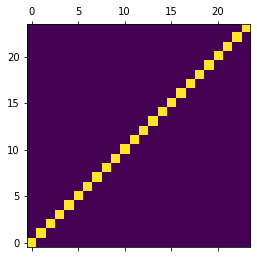

In [4]:
def compute_transition_probabilities(inertia_param = 0.8):
    """
    Matrix of transition probabilities
    """
    modulation_prob = (1 - inertia_param)/23.
    A = (modulation_prob*(np.ones(24)-np.eye(24))
         + inertia_param*np.eye(24))

    return A

# How likely are going to stay in the same key
intertia_param = 0.8
transition_probabilities = compute_transition_probabilities()
key_profile_matrix = build_key_profile_matrix("kp")
print(key_profile_matrix.shape)

plt.matshow(transition_probabilities, aspect="auto", origin="lower")

transition_model = ConstantTransitionModel(transition_probabilities)

In [5]:
hmm = HMM(observation_model=observation_model, transition_model=transition_model)

c


/Users/carlos/miniconda3/envs/miws2021/lib/python3.7/site-packages/partitura/io/importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=57 velocity=0 time=144
  warnings.warn("ignoring MIDI message %s" % msg)
/Users/carlos/miniconda3/envs/miws2021/lib/python3.7/site-packages/partitura/io/importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=60 velocity=0 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/Users/carlos/miniconda3/envs/miws2021/lib/python3.7/site-packages/partitura/io/importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=36 velocity=0 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


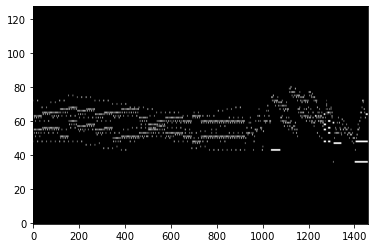

In [7]:
midi_fn = "./example_data/03.mid"
ppart = partitura.load_performance_midi(midi_fn)
note_array = ppart.note_array

time_div = 16
piano_roll = partitura.utils.compute_pianoroll(ppart, time_div=time_div).toarray()
# in seconds
win_size = 2

plt.imshow(piano_roll, origin="lower", aspect="auto", cmap="gray")

n_windows = int(np.ceil(piano_roll.shape[1] / (time_div * win_size)))

window_size = win_size * time_div

observations = np.zeros((n_windows, 12))
for win in range(n_windows):
    idx = slice(win * window_size, (win + 1) * window_size)
    segment = piano_roll[:, idx].sum(1)
    dist = np.zeros(12)
    pitch_idxs = np.where(segment != 0)[0]
    for pix in pitch_idxs:
        dist[pix % 12] += segment[pix]
    dist /= dist.sum()
    observations[win] = dist
    
path, log_lik = hmm.find_best_sequence(observations)

key_idx = int(mode(path).mode[0])

key = KEYS[key_idx]

for 



print(key)